# 1. Business understanding
The dataset is about conversion rate of a website. The goal is to understand what factors are the most important for conversion rate and come up with recommendations to improve the conversion rate.


# 2. Data understanding

## 2.1 Load libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
%matplotlib inline

## 2.2 Load dataset

In [39]:
data = pd.read_csv('../data/conversion_rate/conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


We can see that there are no missing values in the dataset. The dataset contains 5 columns, including 3 categorical columns and 2 numerical columns. The target variable is 'converted'.

In [5]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


In [6]:
# Check for duplicates
data.duplicated().sum()

299903

We cannot tell if the previous result is duplicated or not, as we don't know the user_id. So let's assume that the user_id is unique and there are no duplicates in the dataset.

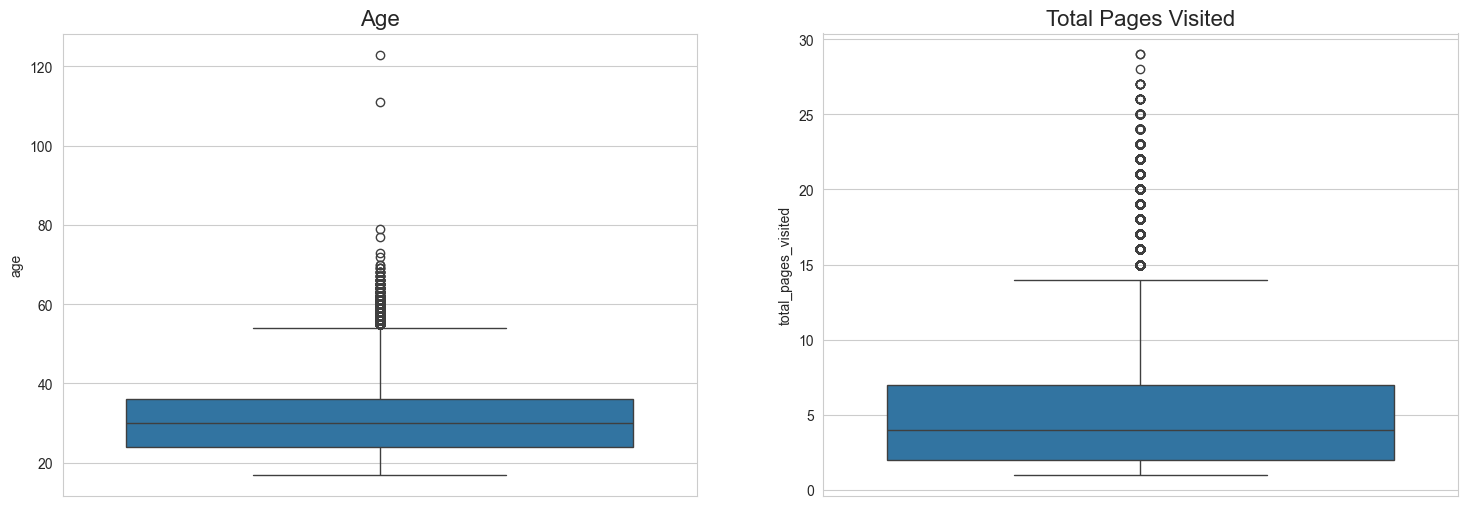

In [7]:
# Set a boxplot to check the distribution of numerical columns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.boxplot(data['age'], ax=ax[0])
ax[0].set_title('Age', fontsize=16)
sns.boxplot(data['total_pages_visited'], ax=ax[1])
ax[1].set_title('Total Pages Visited', fontsize=16)
plt.show()

## 2.3 Remove Outliers
Typically, age should be below 100. So, first let check outliers and clean the dataset

In [8]:
data[data['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


There are only two records that are invalid, let's first remove them directly

In [9]:
data = data[data['age'] < 100]

## 2.4 Exploratory Data Analysis

### 2.4.1 Visualization of different countries

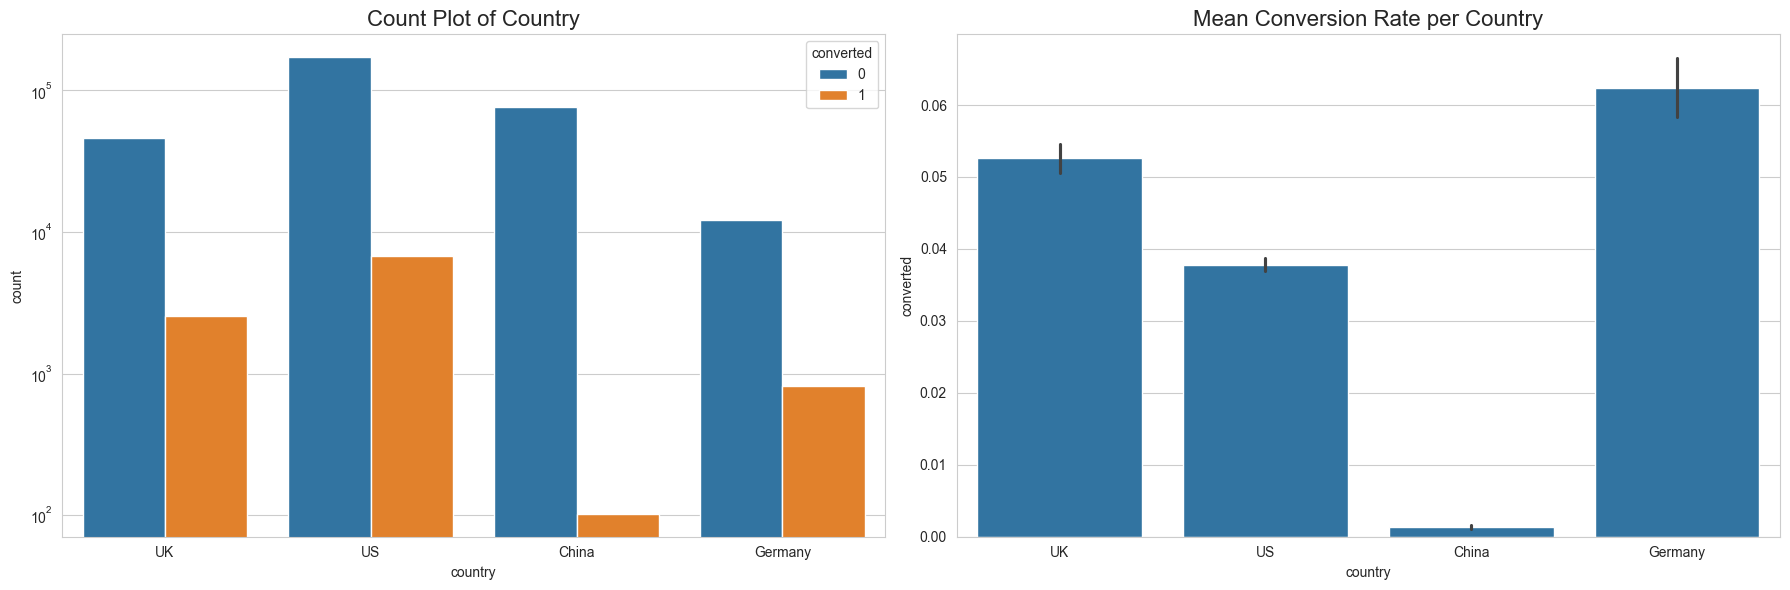

In [10]:
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

### 2.4.2 Visualization of different user types

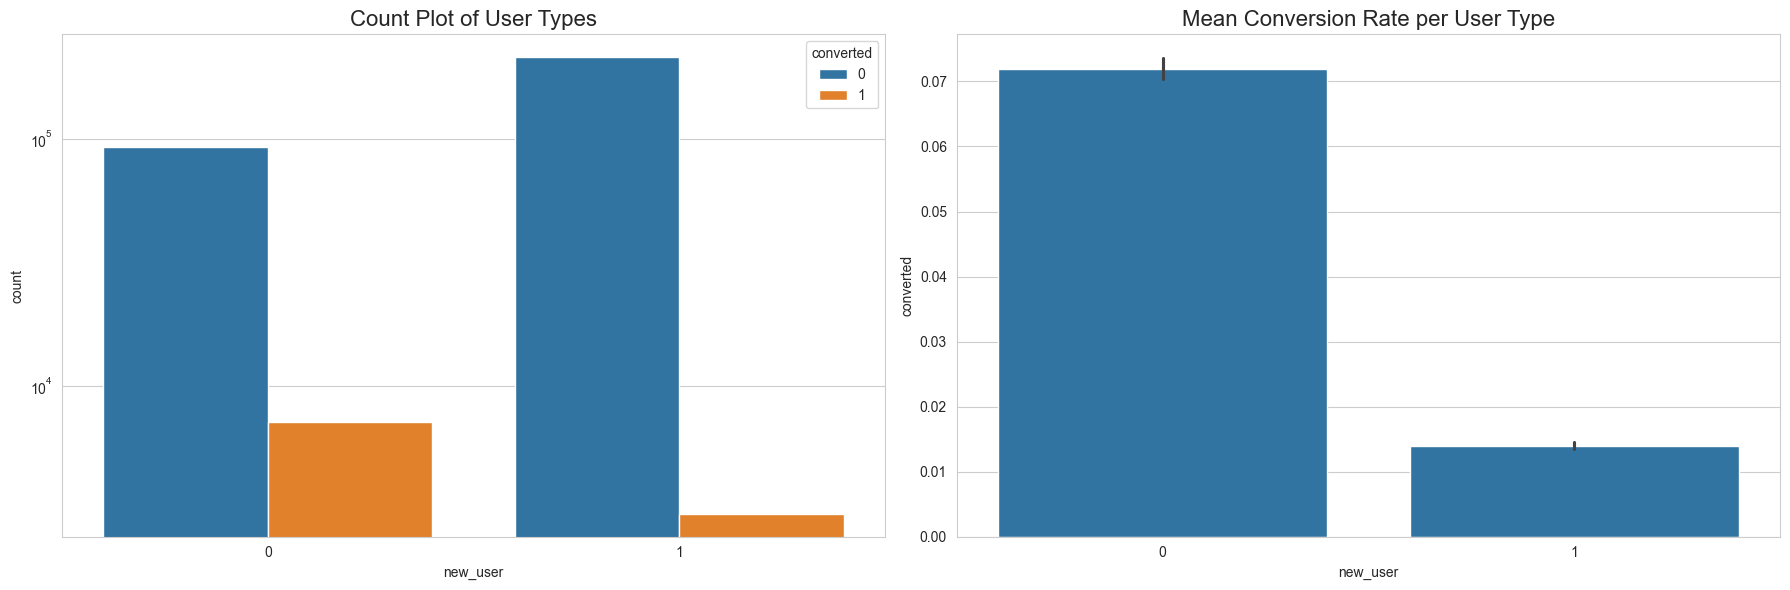

In [11]:

grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

### 2.4.3 Visualization of different sources

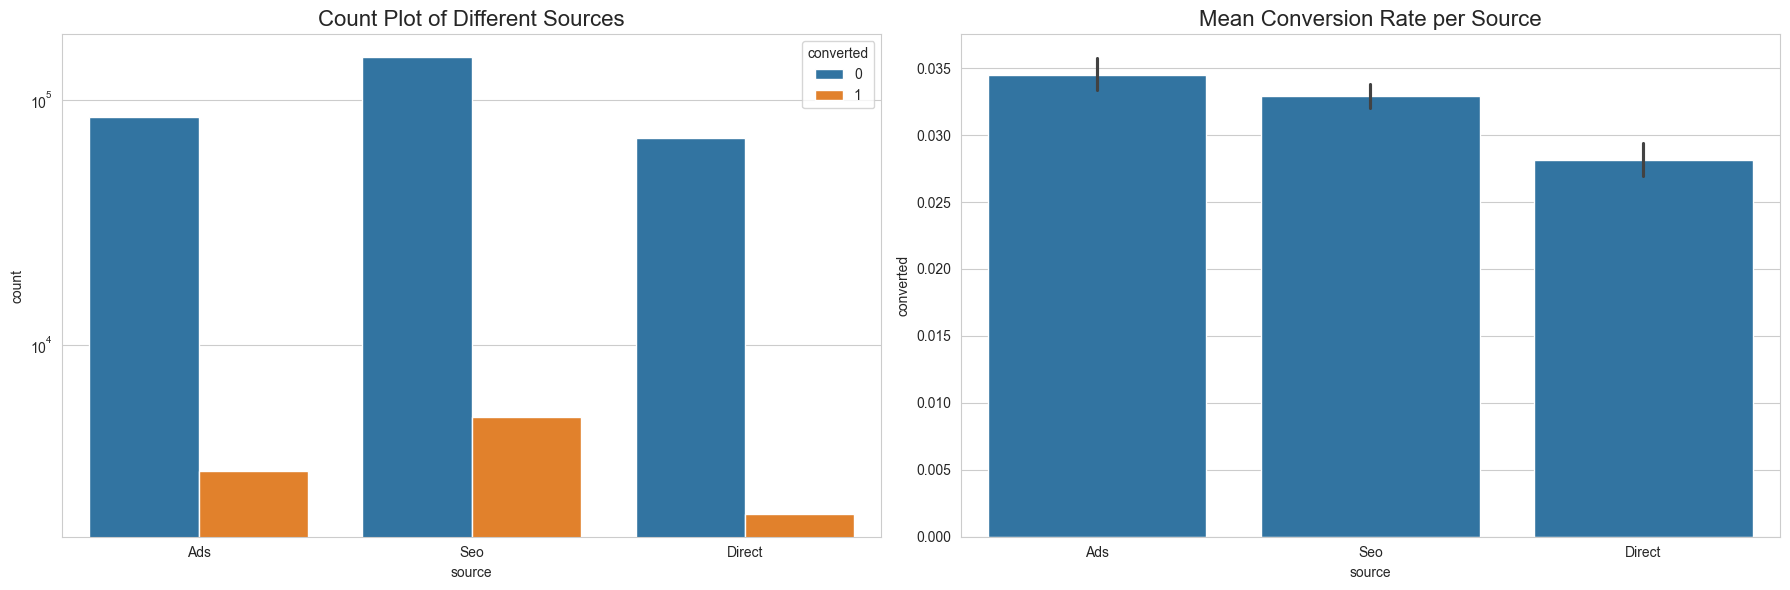

In [12]:

grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

### 2.4.4 Visualization of age

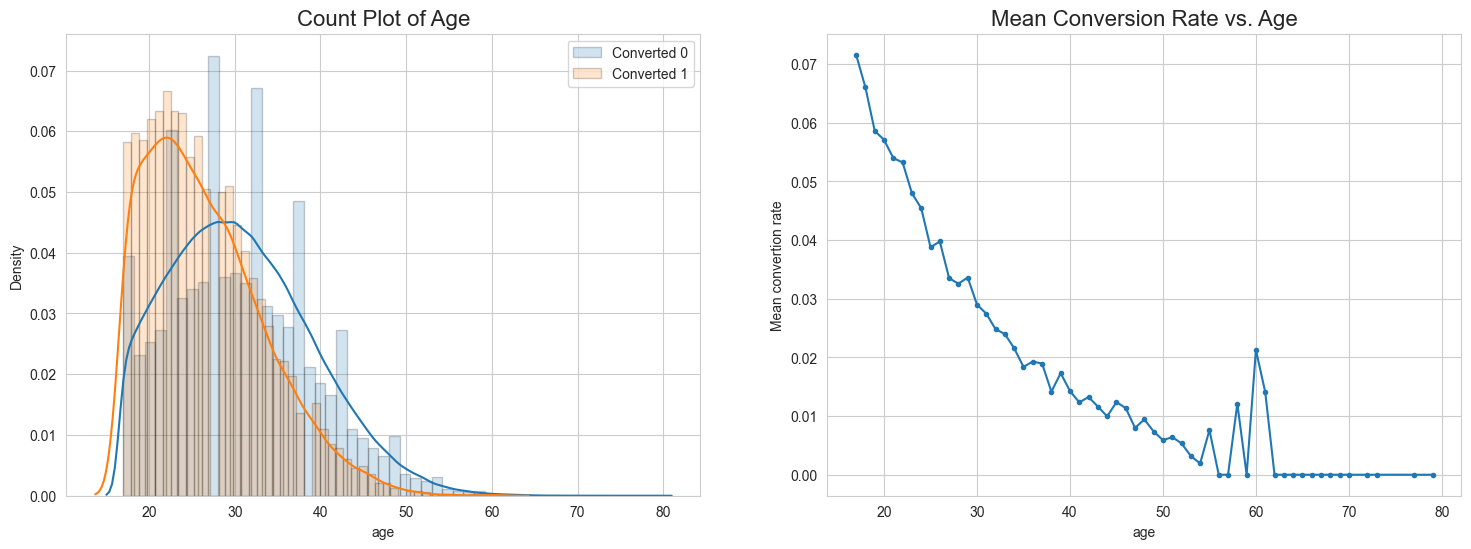

In [13]:
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

### 2.4.5 Visualization of total page visited

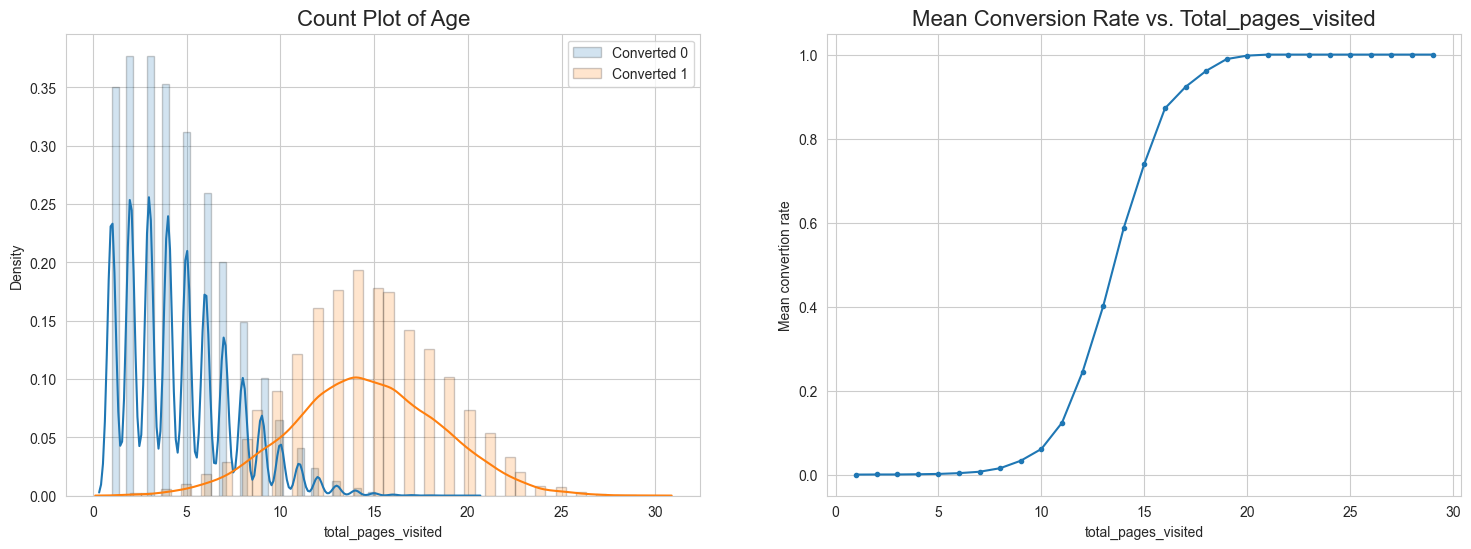

In [14]:
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

# 3. Data Preparation
Now we need to prepare the data for machine learning. We need to convert categorical variables into numerical variables, and split the data into training and test datasets.
We could use one-hot encoding to convert categorical variables into numerical variables. However, for tree-based models, we don't need to do this. We can simply convert the categorical variables into numerical variables using label encoding.


In [15]:
# set noralization for numerical columns
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
data[['age_n', 'total_pages_visited_n']] = normalizer.fit_transform(data[['age', 'total_pages_visited']])
# We can one hot encode the categorical variables
data = pd.get_dummies(data, columns=['country', 'source'], dtype=int)


In [16]:
# This is how the dataset looks like after one-hot encoding
data

,age,new_user,total_pages_visited,converted,age_n,total_pages_visited_n,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0.999201,0.039968,0,0,1,0,1,0,0
1,23,1,5,0,0.977176,0.212430,0,0,0,1,0,0,1
2,28,1,4,0,0.989949,0.141421,0,0,0,1,0,0,1
3,39,1,5,0,0.991882,0.127164,1,0,0,0,0,0,1
4,30,1,6,0,0.980581,0.196116,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316195,26,1,9,0,0.944986,0.327111,0,0,0,1,1,0,0
316196,27,1,6,0,0.976187,0.216930,0,0,0,1,0,1,0
316197,25,0,4,0,0.987441,0.157991,1,0,0,0,1,0,0
316198,22,0,4,0,0.983870,0.178885,0,0,0,1,0,0,1


In [17]:
# To make it cleaner, let's drop the original columns
data_n = data.drop(['age', 'total_pages_visited'], axis=1)
data_n

,new_user,converted,age_n,total_pages_visited_n,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,1,0,0.999201,0.039968,0,0,1,0,1,0,0
1,1,0,0.977176,0.212430,0,0,0,1,0,0,1
2,1,0,0.989949,0.141421,0,0,0,1,0,0,1
3,1,0,0.991882,0.127164,1,0,0,0,0,0,1
4,1,0,0.980581,0.196116,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
316195,1,0,0.944986,0.327111,0,0,0,1,1,0,0
316196,1,0,0.976187,0.216930,0,0,0,1,0,1,0
316197,0,0,0.987441,0.157991,1,0,0,0,1,0,0
316198,0,0,0.983870,0.178885,0,0,0,1,0,0,1


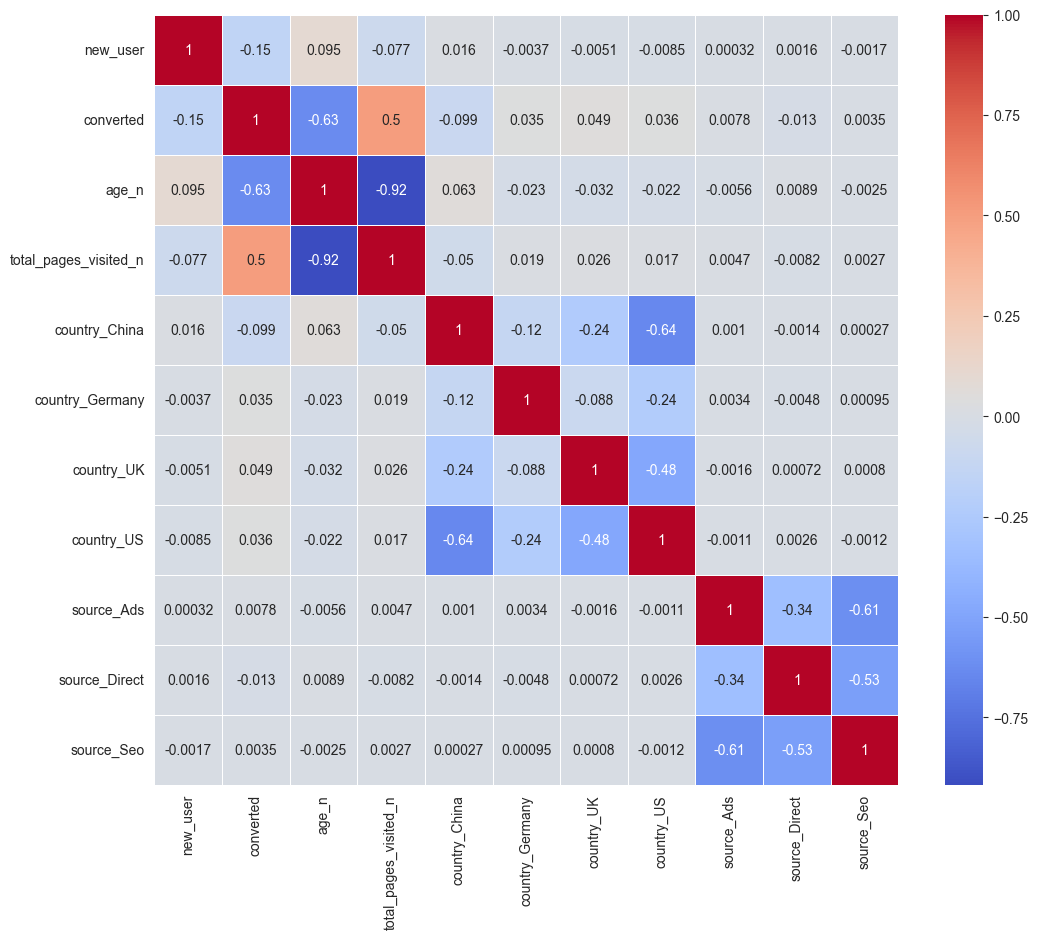

In [18]:
# Let's check the correlation between the variables
plt.figure(figsize=(12, 10))
sns.heatmap(data_n.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.show()


In [19]:
# Let's split the data into training and test datasets
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_n, test_size=0.25, random_state=11)


# 4. Modeling
Now that we have prepared the data, we can start to build the model. We will benchmark the following models:
- Logistic Regression
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM
- Neural Network
- K-Nearest Neighbors
- Naive Bayes
- Decision Tree
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- AdaBoost
- Bagging


In [24]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [25]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'Neural Network': MLPClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier()
}

In [26]:
# Train the models
for name, model in models.items():
    model.fit(train.drop('converted', axis=1), train['converted'])
    print(name + ' trained.')

Logistic Regression trained.
Random Forest trained.
Gradient Boosting trained.
XGBoost trained.
[LightGBM] [Info] Number of positive: 7615, number of negative: 229533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 237148, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032111 -> initscore=-3.405927
[LightGBM] [Info] Start training from score -3.405927
LightGBM trained.
Neural Network trained.
K-Nearest Neighbors trained.
Naive Bayes trained.
Decision Tree trained.
Linear Discriminant Analysis trained.
Quadratic Discriminant Analysis trained.
AdaBoost trained.
Bagging trained.


# 5. Evaluation

In [27]:
# We can now evaluate the models on the test dataset
results = pd.DataFrame(columns=['Accuracy', 'AUC'], index=models.keys())
for name, model in models.items():
    y_pred = model.predict(test.drop('converted', axis=1))
    y_prob = model.predict_proba(test.drop('converted', axis=1))[:, 1]
    results.loc[name, 'Accuracy'] = np.round(accuracy_score(test['converted'], y_pred), 3)
    results.loc[name, 'AUC'] = np.round(roc_auc_score(test['converted'], y_prob), 3)

,Accuracy,AUC
Logistic Regression,0.981,0.979
Random Forest,0.982,0.943
Gradient Boosting,0.982,0.98
XGBoost,0.982,0.979
LightGBM,0.982,0.981
Neural Network,0.981,0.979
K-Nearest Neighbors,0.981,0.898
Naive Bayes,0.961,0.971
Decision Tree,0.982,0.916
Linear Discriminant Analysis,0.977,0.97


In [28]:
results.sort_values('AUC', ascending=False)

,Accuracy,AUC
LightGBM,0.982,0.981
Gradient Boosting,0.982,0.98
AdaBoost,0.981,0.98
Logistic Regression,0.981,0.979
XGBoost,0.982,0.979
Neural Network,0.981,0.979
Quadratic Discriminant Analysis,0.831,0.974
Naive Bayes,0.961,0.971
Linear Discriminant Analysis,0.977,0.97
Random Forest,0.982,0.943


It seems that Light GBM has the best performance. Let's use Light GBM to build the model and check the feature importance.

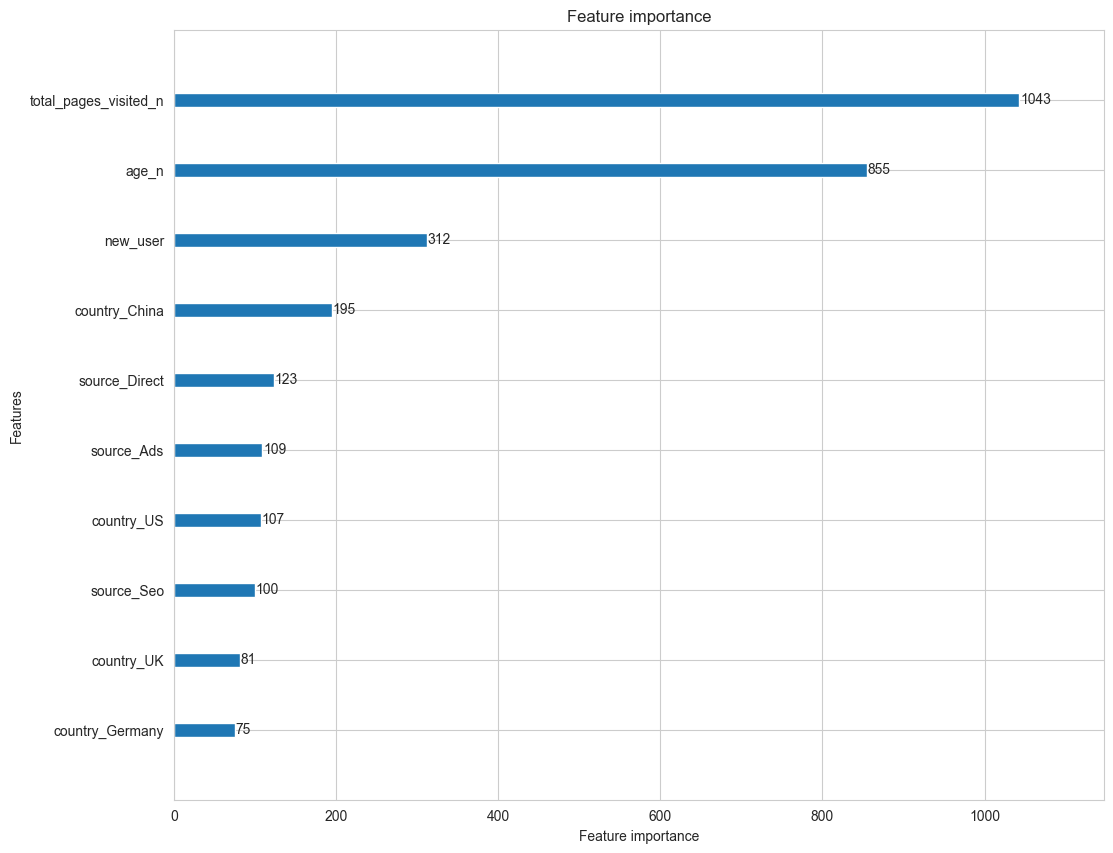

In [32]:
# Plot the feature importance for Light GBM
import lightgbm
model = models['LightGBM']
lightgbm.plot_importance(model, figsize=(12, 10))
plt.show()

We can see that the most important features are total_pages_visited, age, and new_user.
To complete the evaluation, let's check the confusion matrix and classification report for the Light GBM model.

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(test.drop('converted', axis=1))
print(confusion_matrix(test['converted'], y_pred))
print(classification_report(test['converted'], y_pred))

[[76133   334]
 [ 1075  1508]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76467
           1       0.82      0.58      0.68      2583

    accuracy                           0.98     79050
   macro avg       0.90      0.79      0.84     79050
weighted avg       0.98      0.98      0.98     79050


Let's plot the AUC for the Light GBM model.


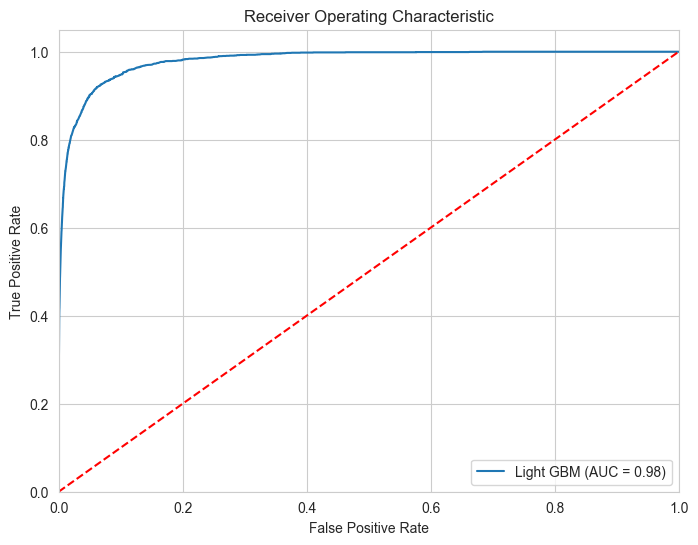

In [34]:
# Plot the AUC for the Light GBM model
fpr, tpr, thresholds = roc_curve(test['converted'], model.predict_proba(test.drop('converted', axis=1))[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Light GBM (AUC = %0.2f)' % roc_auc_score(test['converted'], model.predict_proba(test.drop('converted', axis=1))[:, 1]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 6. Deployment
For the deployment, let's build the pipeline to transform the data and train the model. We will use the Light GBM model to build the pipeline.


In [35]:
# Import libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from lightgbm import LGBMClassifier

In [40]:
# Define the pipeline
categorical_features = ['country', 'source']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# Preprocessing for numerical data
numerical_features = ['age', 'total_pages_visited']
numerical_transformer = Pipeline(steps=[
    ('normalizer', Normalizer())])
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
# Define the model
model = LGBMClassifier()
# Create and evaluate the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
# Train the model
pipeline.fit(data.drop('converted', axis=1), data['converted'])

[LightGBM] [Info] Number of positive: 10200, number of negative: 306000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 316200, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032258 -> initscore=-3.401197
[LightGBM] [Info] Start training from score -3.401197


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('normalizer',
                                                                   Normalizer())]),
                                                  ['age',
                                                   'total_pages_visited']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country', 'source'])])),
                ('model', LGBMClassifier())])

In [42]:
# Save the pipeline
import joblib
joblib.dump(pipeline, '../models/conversion_rate_pipeline.pkl')



['../models/conversion_rate_pipeline.pkl']